In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [6]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [7]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [8]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [9]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [10]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [11]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

comment  label
0  str_Declaration     -1

In [12]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 1200)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 1200)

In [13]:
# 첫번째 행 제거
data = data.drop(0)

In [14]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
data[:5]

comment  label
0  주인공의 결정이 어떻든.. 솔직히 마음이 좀 무거워지네요. 사과와 용서의 무게가 느...      0
1  조폭새끼들 싸움 못한다고 착각하는 애들이 병신같음 저새끼들 태반이 유도 씨름 복싱 선출임      2
2                                      더 좋은 작품 기대합니다      0
3           감동적이다. 그냥 야한영화 아니다. 사랑에 대해 생각하게 하는 영화...      0
4                      꽃뱀 천지로구나. 정권이 바껴야 좀 잠잠해질라나???      1

## 중복 및 null 처리

In [16]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [17]:
detect_overlap(data)

In [18]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [19]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [20]:
x_data = hate_data['comment']
y_data = hate_data['label']

In [21]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [22]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [23]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 149925
단어 집합(vocabulary)에서 희귀 단어의 비율: 75.61086315152433
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 19.37180689826264


## 훈련 데이터, 테스트 데이터 분리

In [24]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [25]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

## 문장 길이 분포 확인

문장 최대 길이 : 59
문장 평균 길이 : 7.739340


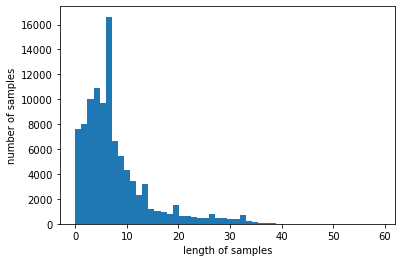

In [26]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [27]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.01, X_data)

In [28]:
# 가장 긴 길이로 맞추기
data = pad_sequences(X_data, maxlen = maxlen)

In [29]:
X_test, y_test, X_train, y_train = config_dataset(numtrain, data)

In [30]:
X_train

array([[     0,      0,      0, ...,     80,   2914,     81],
       [     0,      0,      0, ...,   4674,  48362,  48363],
       [     0,      0,      0, ...,     57,   1351,   1082],
       ...,
       [     0,      0,      0, ...,      3,    487,     48],
       [     0,      0,      0, ...,      0,      0,     55],
       [     0,      0,      0, ..., 168766,     31,  13363]])

In [31]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
import pandas as pd
import tensorflow.keras.metrics 

In [33]:
size = 1000000
model = Sequential()
model.add(Embedding(size ,256, input_length = maxlen)) #워드 임베딩
model.add(Dropout(0.2)) #과적합 방지를 위해 일부 Drop, 기본 20% 정도를 Drop하도록 설정함.
model.add(Conv1D(128, 3, padding='valid', activation='relu')) #hidden layer 추가
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) #과적합 방지를 위해 일부 Drop, 기본 20% 정도를 Drop하도록 설정함.
num_of_class = 2 #클래스는 우선 4개로 분류함
model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 256)           256000000 
_________________________________________________________________
dropout (Dropout)            (None, 59, 256)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 57, 128)           98432     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics= ["acc"])

In [ ]:
model.fit(X_train, y_train, batch_size = 64, epochs=10)

Epoch 1/10
   2/1250 [..............................] - ETA: 6:41:34 - loss: 0.6943 - acc: 0.3047

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))